In [3]:
#In case reader wants to input arguments ar commandline
#db = 'imdb' 
#parser = argparse.ArgumentParser(description='Gender and Age Detection')
#parser.add_argument('-i', '--input', required='True', type=str, help='Input dir for images')
#args = parser.parse_args("--i data/{}_crop/{}.mat".format(db, db).split()) #set the values of the passed variables

#metadata_path=args.input


In [25]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [26]:
dbs=['imdb','wiki']

for i, db in enumerate(dbs):
    parent_dir='data/{}/'.format(db)
    metadata_path=parent_dir+'{}.mat'.format(db)
    db_mat = loadmat(metadata_path) #https://towardsdatascience.com/how-to-load-matlab-mat-files-in-python-1f200e1287b5
    db_data=db_mat[db]#https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html
#    print(db,db_mat.keys())
#    print(i,db,db_data.dtype)
    
    if(db=='imdb'):
        dob=db_data[0,0]['dob'][0]
        photo_taken=db_data[0,0]['photo_taken'][0]
        full_path=db_data[0,0]['full_path'][0]
        gender=db_data[0,0]['gender'][0]
        face_score=db_data[0,0]['face_score'][0]
        second_face_score=db_data[0,0]['second_face_score'][0]
        imdb_df=pd.DataFrame({"dob":dob,"photo_taken":photo_taken,"full_path": full_path,"gender": gender,"face_score": face_score,"second_face_score":second_face_score})        
        no_of_images=len(full_path)
        print(db,no_of_images)
    else:
        dob=db_data[0,0]['dob'][0]
        photo_taken=db_data[0,0]['photo_taken'][0]
        full_path=db_data[0,0]['full_path'][0]
        gender=db_data[0,0]['gender'][0]
        face_score=db_data[0,0]['face_score'][0]
        second_face_score=db_data[0,0]['second_face_score'][0]
        wiki_df=pd.DataFrame({"dob":dob,"photo_taken":photo_taken,"full_path": full_path,"gender": gender,"face_score": face_score,"second_face_score":second_face_score})
        no_of_images=len(full_path)
        print(db,no_of_images)            

imdb 460723
wiki 62328


In [27]:
# Calculate age at the time the photo was taken: get difference between 'dob' and 'photo_taken'

# 'dob' is given as a Matlab serial date number. In MATLAB, serial date number 1 is January 1, 0000. Serial time can 
# represent fractions of days beginning at midnight; for example, 6 p.m. equals 0.75 serial days. We need to utilize
# Python function 'date.fromordinal' to convert the serial date. 
# Ref 1: http://sociograph.blogspot.com/2011/04/how-to-avoid-gotcha-when-converting.html
# Ref 2: https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python

# 'photo_taken' is a list of years the photo was taken. In the dataset, it's assumed that the photo was taken 
# in the middle of the year

import time
from datetime import datetime, date, timedelta

def calculate_age(dob, taken_year):
# sanity check
#    print(taken_date.dtype)
#    print(dob.dtype)
# The following function takes only one value at a time, and becasue we're doing a subtraction to correct from ordinal
# date, need a max() to make sure there are no negatives
    birth_python = datetime.fromordinal(max(int(dob) - 366,1))   
    birth_year=birth_python.year
# today's date: to calculate current age, but doesn't make much sense 
#    current_year = date.today().year
    
    if (birth_python.month<=6):
        age_phototaken=taken_year-birth_year
#        age_current=current_year-birth_year
    else:
        age_phototaken=taken_year-birth_year-1
#        age_current=current_year-birth_year-1
#    return age_phototaken,age_current    
    return age_phototaken

imdb_age=imdb_df.apply(lambda row: calculate_age(row['dob'],row['photo_taken']),axis=1)
imdb_df['age']=imdb_age

wiki_age=wiki_df.apply(lambda row: calculate_age(row['dob'],row['photo_taken']),axis=1)
wiki_df['age']=wiki_age

print(imdb_df.head(10))

#This works for one set of array values:
#age=[calculate_age(dob[i],photo_taken[i]) for i in range(len(dob))]

#if current age is needed:
#to unpack multiple values with list comprehension (returns tuple, so reverse by using map(list,..):
#age_phototaken,age_current =map(list,zip(*[calculate_age(dob[i],photo_taken[i]) for i in range(len(dob))]))

      dob  photo_taken                                       full_path  \
0  693726         1968   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]   
1  693726         1970  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]   
2  693726         1968   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]   
3  693726         1968   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
4  693726         1968   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]   
5  702986         1991  [02/nm0000002_rm1075631616_1924-9-16_1991.jpg]   
6  702986         2004  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
7  702986         2004  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
8  702986         1991  [02/nm0000002_rm1411175936_1924-9-16_1991.jpg]   
9  702986         2004  [02/nm0000002_rm1447271168_1924-9-16_2004.jpg]   

   gender  face_score  second_face_score  age  
0     1.0    1.459693           1.118973   69  
1     1.0    2.543198           1.852008   71  
2     1.0    3.455579           2.985660 

In [28]:
# Check validity of images
# Conditions:
# 1) gender: Ignore images with unknown gender (NaN if unknown)
# 2) face_score: Ignore images with no face (Inf implies that no face was found)
# 3) second_face_score: Images with second face will be ignored (NaN if no second face)
# 4) age: age range from -31->2014, only pick valid values
def get_valid(gender,face_score,second_face_score,age):
#    valid_images=True
    if np.isnan(gender):
        valid_images=False
    elif face_score<1.0 or np.isinf(face_score):
#Ref: http://www.apsipa.org/proceedings/2018/pdfs/0000007.pdf (Drop images with face_score<1)        
        valid_images=False
    elif ~np.isnan(second_face_score):
        valid_images=False
    elif age<0 or age>100:
        valid_images=False
    else:
        valid_images=True
    return valid_images
    

In [29]:
#Select valid images on the IMDB dataset
imdb_valid_images=imdb_df.apply(lambda row: get_valid(row['gender'],row['face_score'],row['second_face_score'],row['age']) , axis=1)
imdb_df['valid_images']=imdb_valid_images
print(imdb_df['valid_images'].value_counts())

# Save imdb valid images
imdb_valid_df=imdb_df.loc[imdb_df['valid_images'],['full_path','gender','age']].reset_index(drop=True)
print(imdb_valid_df.head())

False    288871
True     171852
Name: valid_images, dtype: int64
                                        full_path  gender  age
0   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]     1.0   69
1   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]     1.0   69
2  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]     0.0   79
3  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]     0.0   79
4   [02/nm0000002_rm221957120_1924-9-16_1974.jpg]     0.0   49


In [30]:
#Update full path to complete path on the IMDB dataset

imdb_valid_df.loc[:, 'full_path'] = imdb_valid_df.full_path.map(lambda x: 'data/imdb/'+x[0])
#print(imdb_valid_df.full_path)
print(imdb_valid_df.head())
print(imdb_valid_df.tail())

                                           full_path  gender  age
0  data/imdb/01/nm0000001_rm946909184_1899-5-10_1...     1.0   69
1  data/imdb/01/nm0000001_rm980463616_1899-5-10_1...     1.0   69
2  data/imdb/02/nm0000002_rm1346607872_1924-9-16_...     0.0   79
3  data/imdb/02/nm0000002_rm1363385088_1924-9-16_...     0.0   79
4  data/imdb/02/nm0000002_rm221957120_1924-9-16_1...     0.0   49
                                                full_path  gender  age
171847  data/imdb/08/nm3994408_rm73386752_1989-12-29_2...     0.0   21
171848  data/imdb/08/nm3994408_rm744468480_1989-12-29_...     0.0   21
171849  data/imdb/08/nm3994408_rm761245696_1989-12-29_...     0.0   21
171850  data/imdb/08/nm3994408_rm943369728_1989-12-29_...     0.0   21
171851  data/imdb/08/nm3994408_rm976924160_1989-12-29_...     0.0   21


In [31]:
#Select valid images on the wiki dataset

wiki_valid_images=wiki_df.apply(lambda row: get_valid(row['gender'],row['face_score'],row['second_face_score'],row['age']) , axis=1)
wiki_df['valid_images']=wiki_valid_images
print(wiki_df['valid_images'].value_counts())

# Save wiki valid images
wiki_valid_df=wiki_df.loc[wiki_df['valid_images'],['full_path','gender','age']].reset_index(drop=True)
print(wiki_valid_df.head())

True     38138
False    24190
Name: valid_images, dtype: int64
                           full_path  gender  age
0  [17/10000217_1981-05-05_2009.jpg]     1.0   28
1    [12/100012_1948-07-03_2008.jpg]     1.0   59
2  [16/10002116_1971-05-31_2012.jpg]     0.0   41
3  [02/10002702_1960-11-09_2012.jpg]     0.0   51
4  [41/10003541_1937-09-27_1971.jpg]     1.0   33


In [32]:
#Update full path to complete path on the wiki dataset

wiki_valid_df.loc[:, 'full_path'] = wiki_valid_df.full_path.map(lambda x: 'data/wiki/'+x[0])
#print(wiki_valid_df.full_path)
print(wiki_valid_df.head())
print(wiki_valid_df.tail())

                                   full_path  gender  age
0  data/wiki/17/10000217_1981-05-05_2009.jpg     1.0   28
1    data/wiki/12/100012_1948-07-03_2008.jpg     1.0   59
2  data/wiki/16/10002116_1971-05-31_2012.jpg     0.0   41
3  data/wiki/02/10002702_1960-11-09_2012.jpg     0.0   51
4  data/wiki/41/10003541_1937-09-27_1971.jpg     1.0   33
                                      full_path  gender  age
38133  data/wiki/38/9996938_1937-02-15_1968.jpg     1.0   31
38134  data/wiki/46/9996946_1943-11-01_1968.jpg     1.0   24
38135  data/wiki/49/9996949_1937-04-17_1963.jpg     1.0   26
38136  data/wiki/09/9998109_1972-12-27_2013.jpg     1.0   40
38137   data/wiki/80/999980_1954-06-11_2008.jpg     0.0   54


In [33]:
#Put them together
#print('data/imdb/'+imdb_df.full_path[10][0])  
valid_df = pd.concat([imdb_valid_df,wiki_valid_df],axis=0)
valid_df.head(10)

,full_path,gender,age
0,data/imdb/01/nm0000001_rm946909184_1899-5-10_1...,1.0,69
1,data/imdb/01/nm0000001_rm980463616_1899-5-10_1...,1.0,69
2,data/imdb/02/nm0000002_rm1346607872_1924-9-16_...,0.0,79
3,data/imdb/02/nm0000002_rm1363385088_1924-9-16_...,0.0,79
4,data/imdb/02/nm0000002_rm221957120_1924-9-16_1...,0.0,49
5,data/imdb/02/nm0000002_rm2287049216_1924-9-16_...,0.0,82
6,data/imdb/02/nm0000002_rm238734336_1924-9-16_1...,0.0,49
7,data/imdb/02/nm0000002_rm2585828096_1924-9-16_...,0.0,81
8,data/imdb/02/nm0000002_rm2769394176_1924-9-16_...,0.0,81
9,data/imdb/02/nm0000002_rm2780403712_1924-9-16_...,0.0,79


In [34]:
valid_df.tail(5)

,full_path,gender,age
38133,data/wiki/38/9996938_1937-02-15_1968.jpg,1.0,31
38134,data/wiki/46/9996946_1943-11-01_1968.jpg,1.0,24
38135,data/wiki/49/9996949_1937-04-17_1963.jpg,1.0,26
38136,data/wiki/09/9998109_1972-12-27_2013.jpg,1.0,40
38137,data/wiki/80/999980_1954-06-11_2008.jpg,0.0,54


In [35]:
valid_df.describe()

,gender,age
count,209990.000000,209990.000000
mean,0.582537,36.699633
std,0.493142,13.730862
min,0.000000,0.000000
25%,0.000000,27.000000
50%,1.000000,35.000000
75%,1.000000,44.000000
max,1.000000,100.000000


In [36]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209990 entries, 0 to 38137
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   full_path  209990 non-null  object 
 1   gender     209990 non-null  float64
 2   age        209990 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [37]:
valid_df.gender=valid_df.gender.astype('int32')

0 0 Gender: 1 Age: 69
0 1 Gender: 0 Age: 82
0 2 Gender: 0 Age: 66
1 0 Gender: 1 Age: 29
1 1 Gender: 1 Age: 48
1 2 Gender: 1 Age: 66
2 0 Gender: 1 Age: 72
2 1 Gender: 1 Age: 37
2 2 Gender: 1 Age: 51


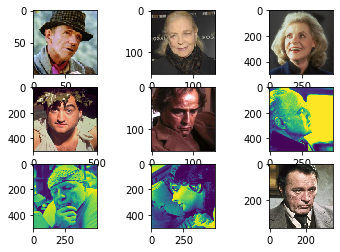

In [38]:
# plot the first 9 images in the valid dataset
from matplotlib import pyplot
from matplotlib.image import imread

# plot first few images
#for i in range(9):
#    pyplot.subplot(3,3,i+1)
#    filename=valid_df.values[i][0]
#    image=imread(filename)
#    pyplot.imshow(image)
#    pyplot.show()
#pyplot.show()   

f, axarr = plt.subplots(3,3)
count=0
for i in range(3):
    for j in range(3):
        filename=valid_df.values[count][0]
        image=imread(filename)
        axarr[i,j].imshow(image)
        print(i,j,"Gender:",valid_df.values[count][1],"Age:",valid_df.values[count][2])
        count+=10
        
#The second image is mislabeled

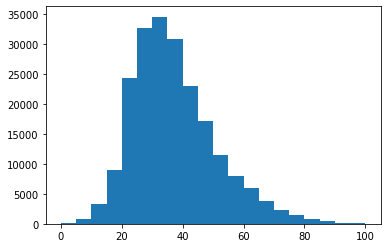

bin_start bin_end count cumulative_count
0.0 5.0 128.0 128.0
5.0 10.0 841.0 969.0
10.0 15.0 3274.0 4243.0
15.0 20.0 8924.0 13167.0
20.0 25.0 24363.0 37530.0
25.0 30.0 32595.0 70125.0
30.0 35.0 34494.0 104619.0
35.0 40.0 30775.0 135394.0
40.0 45.0 22941.0 158335.0
45.0 50.0 17174.0 175509.0
50.0 55.0 11444.0 186953.0
55.0 60.0 8010.0 194963.0
60.0 65.0 5881.0 200844.0
65.0 70.0 3825.0 204669.0
70.0 75.0 2374.0 207043.0
75.0 80.0 1529.0 208572.0
80.0 85.0 816.0 209388.0
85.0 90.0 384.0 209772.0
90.0 95.0 164.0 209936.0
95.0 100.0 54.0 209990.0


In [39]:
(n, bins, patches)=plt.hist(x=valid_df.age,bins=20);
plt.show();
total_count=0
print('bin_start','bin_end','count','cumulative_count')
for bin, count in zip(bins,n):
    total_count+=count
    print(bin,bin+5,count,total_count)

# apply augmentation for certain age groups?
# downsample the ones that are more common?

We observe class imbalance in the age data. Ideally, this should be an uniform distribution. 

In [40]:
valid_df.gender.value_counts()
# Note: 0 for female and 1 for male
# There are more valid images of males than females. 


1    122327
0     87663
Name: gender, dtype: int64

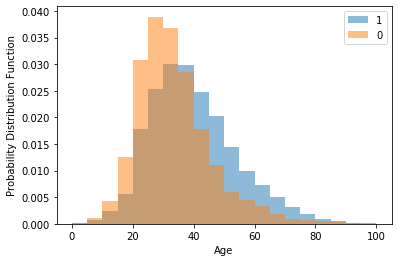

In [41]:
categories = valid_df['gender'].unique()

for c in categories:
    plt.hist(valid_df[valid_df['gender'] == c]['age'], alpha=0.5, label=c, bins=20, density=True)
plt.legend()
plt.ylabel('Probability Distribution Function')
plt.xlabel('Age')
plt.show()

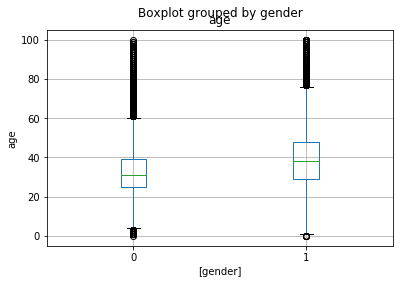

In [42]:
valid_df[['age', 'gender']].boxplot(by='gender')
plt.ylabel('age')
plt.show()

In [43]:
valid_df.head(10)

,full_path,gender,age
0,data/imdb/01/nm0000001_rm946909184_1899-5-10_1...,1,69
1,data/imdb/01/nm0000001_rm980463616_1899-5-10_1...,1,69
2,data/imdb/02/nm0000002_rm1346607872_1924-9-16_...,0,79
3,data/imdb/02/nm0000002_rm1363385088_1924-9-16_...,0,79
4,data/imdb/02/nm0000002_rm221957120_1924-9-16_1...,0,49
5,data/imdb/02/nm0000002_rm2287049216_1924-9-16_...,0,82
6,data/imdb/02/nm0000002_rm238734336_1924-9-16_1...,0,49
7,data/imdb/02/nm0000002_rm2585828096_1924-9-16_...,0,81
8,data/imdb/02/nm0000002_rm2769394176_1924-9-16_...,0,81
9,data/imdb/02/nm0000002_rm2780403712_1924-9-16_...,0,79


In [44]:
from tqdm import tqdm
import cv2
from skimage import io

images = []
ages = []
genders = []
#img_dim=64
img_dim=32

#total_count=valid_df.full_path.count()
total_count=10000

for i in tqdm(range(total_count)):
    impath=valid_df.values[i][0]
    image = io.imread(impath)
    image = cv2.resize(image, (img_dim,img_dim)) 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    images.append(image) #Check image format 
    genders.append(valid_df.values[i][1])
    ages.append(valid_df.values[i][2])


  3%|▎         | 298/10000 [00:18<09:34, 16.88it/s]


  6%|▌         | 594/10000 [00:36<09:36, 16.30it/s]


  9%|▉         | 890/10000 [00:54<08:25, 18.04it/s]


 12%|█▏        | 1184/10000 [01:11<08:18, 17.67it/s]


 15%|█▍        | 1476/10000 [01:28<08:21, 17.00it/s]


 18%|█▊        | 1768/10000 [01:45<07:23, 18.57it/s]


 21%|██        | 2060/10000 [02:02<07:56, 16.65it/s]


 24%|██▎       | 2352/10000 [02:19<07:23, 17.25it/s]


 26%|██▋       | 2644/10000 [02:36<07:00, 17.47it/s]


 29%|██▉       | 2936/10000 [02:54<07:02, 16.71it/s]


 32%|███▏      | 3228/10000 [03:11<06:48, 16.58it/s]


 35%|███▌      | 3520/10000 [03:28<06:07, 17.63it/s]


 38%|███▊      | 3812/10000 [03:46<06:25, 16.06it/s]


 41%|████      | 4104/10000 [04:03<05:40, 17.30it/s]


 44%|████▍     | 4396/10000 [04:21<05:21, 17.42it/s]


 47%|████▋     | 4688/10000 [04:38<05:38, 15.70it/s]


 50%|████▉     | 4981/10000 [04:55<05:09, 16.19it/s]


 53%|█████▎    | 5273/10000 [05:13<04:19, 18.23it/s]


 56%|█████▌    | 5565/10000 [05:30<04:07, 17.95it/s]


 59%|█████▊    | 5857/10000 [05:47<03:59, 17.33it/s]


 62%|██████▏   | 6151/10000 [06:04<04:12, 15.23it/s]


 64%|██████▍   | 6446/10000 [06:20<03:05, 19.13it/s]


 67%|██████▋   | 6745/10000 [06:36<03:30, 15.43it/s]


 70%|███████   | 7037/10000 [06:54<02:49, 17.53it/s]


 73%|███████▎  | 7329/10000 [07:11<02:38, 16.88it/s]


 76%|███████▌  | 7621/10000 [07:28<02:16, 17.38it/s]


 79%|███████▉  | 7913/10000 [07:46<01:57, 17.78it/s]


 82%|████████▏ | 8206/10000 [08:02<01:38, 18.24it/s]


 85%|████████▍ | 8498/10000 [08:19<01:36, 15.55it/s]


 88%|████████▊ | 8790/10000 [08:36<01:09, 17.31it/s]


 91%|█████████ | 9082/10000 [08:53<00:51, 17.88it/s]


 94%|█████████▎| 9374/10000 [09:10<00:44, 14.01it/s]


 97%|█████████▋| 9666/10000 [09:27<00:18, 17.72it/s]


100%|█████████▉| 9958/10000 [09:44<00:02, 17.55it/s]


100%|██████████| 10000/10000 [09:46<00:00, 17.05it/s]


In [45]:
all_images = np.squeeze(images) 
print(all_images.shape)


(10000, 32, 32, 3)


In [46]:
#Normaliza image data
all_images = all_images.astype('float32')
all_images /= 255.

#Q; normalize before or after splitting?

In [47]:
gender_and_age=valid_df.drop('full_path', axis=1)
print(gender_and_age.head())

   gender  age
0       1   69
1       1   69
2       0   79
3       0   79
4       0   49


In [50]:
# split dataset into 80% train and 20% test data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_images, gender_and_age.head(10000),test_size=0.2,random_state=42,shuffle=True)
print('Peek at the training dataset')
print("Samples in Training:",x_train.shape[0])
print(y_train.info())

print('Peek at the testing dataset')
print("Samples in Testing:",x_test.shape[0])
print(y_test.info())
print(y_test.age.values)

Peek at the training dataset
Samples in Training: 8000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 9254 to 7270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   gender  8000 non-null   int32
 1   age     8000 non-null   int64
dtypes: int32(1), int64(1)
memory usage: 156.2 KB
None
Peek at the testing dataset
Samples in Testing: 2000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 6252 to 6929
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   gender  2000 non-null   int32
 1   age     2000 non-null   int64
dtypes: int32(1), int64(1)
memory usage: 39.1 KB
None
[57 61 54 ... 52 44 42]


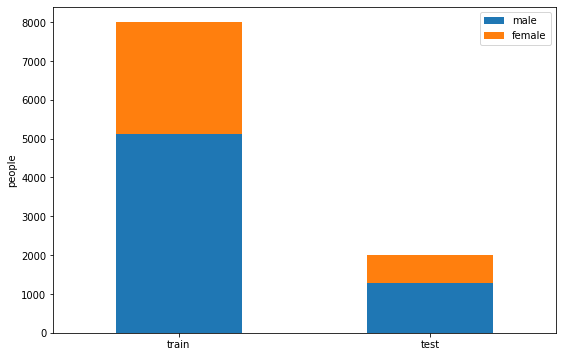

In [51]:
#0 for female, 1 for male
train_test = {'male': [y_train['gender'].value_counts()[1], y_test['gender'].value_counts()[1]],
     'female': [y_train['gender'].value_counts()[0], y_test['gender'].value_counts()[0]]}
count_matrix = pd.DataFrame(train_test)
count_matrix = count_matrix.set_index(pd.Index(['train', 'test']))
count_matrix.plot(kind='bar', stacked=True, rot=0, figsize=(9, 6))
plt.ylabel('people')
plt.legend(loc=1)
plt.show()

In [52]:
import tensorflow as tf
from tensorflow.keras import layers
import keras 
from keras.layers import *
from keras.models import *
from keras.callbacks import EarlyStopping
from keras import backend as K
from IPython.display import Image

Using TensorFlow backend.


In [75]:
inputs = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

#dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model= BatchNormalization()(age_model)
#age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model= BatchNormalization()(age_model)
#age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model= BatchNormalization()(age_model)
#age_model = dropout(age_model)
age_model = Dense(16, activation='relu')(flat)
#age_model = dropout(age_model)
age_model= BatchNormalization()(age_model)
age_model = Dense(8, activation='relu')(age_model)
#age_model = dropout(age_model)
age_model= BatchNormalization()(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)
#can be softmax here 


In [76]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 30, 30, 32)   896         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 14, 14, 64)   0           conv2d_23[0][0]                  
____________________________________________________________________________________________

In [78]:
import random

random_id=random.random()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True)]

#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#validation_steps = TotalvalidationSamples / ValidationBatchSize
#batch_size=128
history = model.fit(x_train,[y_train.age.values,y_train.gender.values],
                    validation_data=(x_test,[y_test.age.values,y_test.gender.values]),epochs = 25, 
                    steps_per_epoch=50,shuffle = True,validation_steps=10,callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/25
50/50 [==============================] - 977s 20s/step - loss: 1960.1133 - dense_57_loss: 1959.4597 - dense_64_loss: 0.6533 - dense_57_accuracy: 0.0000e+00 - dense_64_accuracy: 0.6243 - val_loss: 203.0210 - val_dense_57_loss: 20296.2808 - val_dense_64_loss: 5.8174 - val_dense_57_accuracy: 0.0000e+00 - val_dense_64_accuracy: 6.3550
Epoch 2/25
50/50 [==============================] - 966s 19s/step - loss: 1885.2129 - dense_57_loss: 1884.6223 - dense_64_loss: 0.5904 - dense_57_accuracy: 0.0000e+00 - dense_64_accuracy: 0.6405 - val_loss: 202.8128 - val_dense_57_loss: 20276.0330 - val_dense_64_loss: 5.2443 - val_dense_57_accuracy: 0.0000e+00 - val_dense_64_accuracy: 6.3550
Epoch 3/25
50/50 [==============================] - 1005s 20s/step - loss: 1829.8553 - dense_57_loss: 1829.3157 - dense_64_loss: 0.5398 - dense_57_accuracy: 0.0000e+00 - dense_64_accuracy: 0.6407 - val_loss: 202.9096 - val_dense_57_loss: 20286.0453 - val_dense_64_

In [81]:
model.save('model_data_ipy.h5')
print(history.history.keys())

dict_keys(['val_loss', 'val_dense_57_loss', 'val_dense_64_loss', 'val_dense_57_accuracy', 'val_dense_64_accuracy', 'loss', 'dense_57_loss', 'dense_64_loss', 'dense_57_accuracy', 'dense_64_accuracy'])


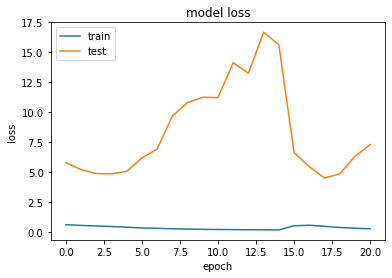

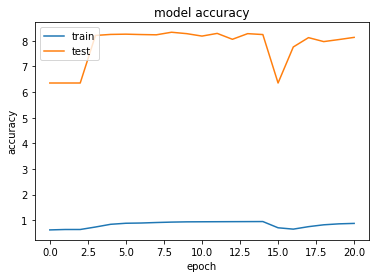

val accuracy: 782.55%


In [84]:
plt.plot(history.history['dense_64_loss'])
plt.plot(history.history['val_dense_64_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_64_accuracy'])
plt.plot(history.history['val_dense_64_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


val_acc = np.mean(history.history['val_dense_64_accuracy'])
print("%s: %.2f%%" % ('val accuracy',(val_acc*100)))

In [93]:
inputs = Input(shape = (32,32, 3))

    # Begin
model2 = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', strides= 2, activation='relu', input_shape=(32, 32, 3))(inputs)
model2 = MaxPool2D(pool_size=(3, 3), strides= 2)(model2)
model2 = BatchNormalization(momentum=0.15)(model2)

model2 = Conv2D(filters=64, kernel_size=(1, 1), padding='SAME', activation='relu')(model2)
model2 = BatchNormalization(momentum=0.15)(model2)
model2 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model2)
model2 = BatchNormalization(momentum=0.15)(model2)

model2 = Conv2D(filters=64, kernel_size=(1, 1), padding='SAME', activation='relu')(model2)
model2 = AveragePooling2D(pool_size=(2, 2), strides= 2)(model2)
model2 = BatchNormalization(momentum=0.15)(model2)

model2 = Conv2D(filters=128, kernel_size=(1, 1), padding='SAME', activation='relu')(model2)
model2 = BatchNormalization(momentum=0.15)(model2)
model2 = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model2)
model2 = BatchNormalization(momentum=0.15)(model2)

model2 = Conv2D(filters=128, kernel_size=(1, 1), padding='SAME', activation='relu')(model2)
#model2 = AveragePooling2D(pool_size=(2, 2), strides= 2)(model2)
model2 = BatchNormalization(momentum=0.15)(model2)
model2 = Conv2D(filters=256, kernel_size=(1, 1), padding='SAME', activation='relu')(model2)
model2 = BatchNormalization(momentum=0.15)(model2)
model2 = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model2)
model2 = BatchNormalization(momentum=0.15)(model2)
model2 = Conv2D(filters=256, kernel_size=(1, 1), padding='SAME', activation='relu')(model2)
#model2 = AveragePooling2D(pool_size=(2, 2), strides= 2)(model2)

model2 = GlobalAveragePooling2D()(model2)

age_model2 = Dense(1024, activation='relu')(model2)
age_model2= Dropout(0.4)(age_model2)
age_model2 = Dense(1, activation='relu',name='age')(age_model2)

gender_model2 = Dense(1024, activation='sigmoid')(model2)
gender_model2 = Dropout(0.4)(gender_model2)
gender_model2 = Dense(1, activation='sigmoid',name='gender')(gender_model2)


In [94]:
model = Model(inputs=inputs, outputs=[age_model2,gender_model2])
model.compile(optimizer = tf.keras.optimizers.Adam(0.00002), loss ={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae',"gender":"accuracy"})
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 16, 16, 256)  7168        input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 7, 7, 256)    0           conv2d_65[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 7, 7, 256)    1024        max_pooling2d_21[0][0]           
___________________________________________________________________________________________

In [100]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True)]
#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#validation_steps = TotalvalidationSamples / ValidationBatchSize
BATCH_SIZE=128
history = model.fit(x_train,[y_train.age.values,y_train.gender.values],
                    validation_data=(x_test,[y_test.age.values,y_test.gender.values]),epochs = 2, 
                    steps_per_epoch=x_train.shape[0]//BATCH_SIZE,shuffle = True,
                    validation_steps=x_test.shape[0]//BATCH_SIZE,callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
21/62 [=========>....................] - ETA: 12:07 - loss: 24.6226 - age_loss: 23.9744 - gender_loss: 0.6483 - age_mae: 23.9744 - gender_accuracy: 0.6363

KeyboardInterrupt: 

In [97]:
model.save('model_ipy.h5')
print(history.history.keys())

dict_keys(['val_loss', 'val_age_loss', 'val_gender_loss', 'val_age_mae', 'val_gender_accuracy', 'loss', 'age_loss', 'gender_loss', 'age_mae', 'gender_accuracy'])


/Users/varuni/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


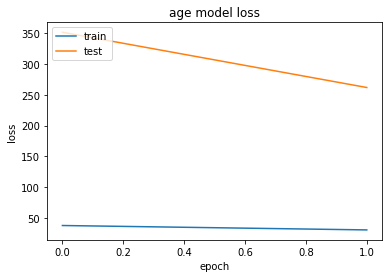

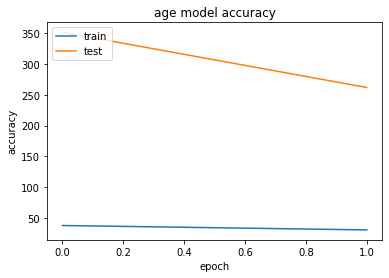

In [98]:
plt.plot(history.history['age_loss'])
plt.plot(history.history['val_age_loss'])
plt.title('age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('age model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


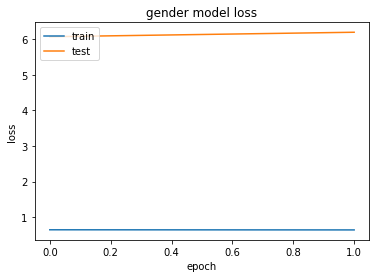

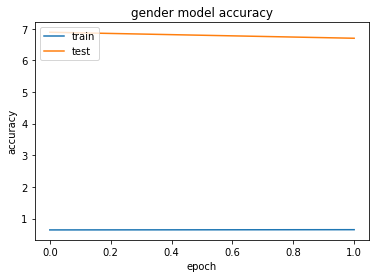

In [99]:
plt.plot(history.history['gender_loss'])
plt.plot(history.history['val_gender_loss'])
plt.title('gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('gender model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# SCALE AGES????
Ref: https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

In [ ]:
# Reg and classification: https://www.kaggle.com/rahuldshetty/age-and-gender-estimation-using-cnn
#https://www.kaggle.com/werty12121/utkface-age-and-sex-prediction


##Parse and save the data to TFRecord files

##Define two helper functions to parse int and bytes features.
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

##Converts a TF dataset to tfrecords
##Ref: https://docs.databricks.com/applications/deep-learning/data-prep/tensorflow-to-tfrecords.html
import tensorflow as tf
from tqdm import tqdm
import cv2
from skimage import io


def convert_and_save_to(df,name,img_dim):

  filename = os.path.join('data', name + '.tfrecords')
  print('Writing', filename)
  count=df.full_path.count()
  print(count)
    
  with tf.io.TFRecordWriter(filename) as writer:
    for i in tqdm(range(count)):
      image = io.imread(df.values[i][0]) 
      image = cv2.resize(image, (img_dim,img_dim))
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  
      image_raw = image.tostring()
      feature={'gender': _int64_feature(int(df.values[i][1])),
              'age': _int64_feature(int(df.values[i][2])),
              'image_raw': _bytes_feature(image_raw)
              }
      features=tf.train.Features(feature=feature)
      # Create an example protocol
      example = tf.train.Example(features=features)
      # Serialize the Example to string and write out 
      writer.write(example.SerializeToString())
        

convert_and_save_to(train,'train',128)
convert_and_save_to(test,'test',128)

# Gender Classification

# We need to setup a training data directory and validation data directory containing one subdirectory per 
# image class, filled with .png or .jpg images.

train_path='data/gender/train/'

#Set up output folders
genderdir_train_f = os.path.join(train_path,'female')
genderdir_train_m = os.path.join(train_path,'male')

if not os.path.exists(genderdir_train_f):
    os.makedirs(genderdir_train_f)
    
if not os.path.exists(genderdir_train_m):
    os.makedirs(genderdir_train_m)

test_path='data/gender/test/'

genderdir_test_f = os.path.join(test_path,'female')
genderdir_test_m = os.path.join(test_path,'male')

if not os.path.exists(genderdir_test_f):
    os.makedirs(genderdir_test_f)

if not os.path.exists(genderdir_test_m):
    os.makedirs(genderdir_test_m)



import csv

train_csv = open(train_path+'train.csv', 'w')
train_writer = csv.writer(train_csv, delimiter=',', )
train_writer.writerow(['filename', 'gender', 'age'])

test_csv = open(test_path+'test.csv', 'w')
test_writer = csv.writer(test_csv, delimiter=',', )
test_writer.writerow(['filename', 'gender', 'age'])

#Get training data in proper format
from tqdm import tqdm
import cv2
from skimage import io

#***update required image size here
#images need to be square to be input into deep learning architecture

img_dim=128

count_f=0
count_m=0

train_count=train.full_path.count()
#train_count=10


for i in tqdm(range(train_count)):
    train_impath=train.values[i][0]
#    img=cv2.imread(train_impath)
    img = io.imread(train_impath)
#    print(i,train.values[i][0],train.values[i][1],train.values[i][2])
# If resizing is needed, make sure the images don't get distorted too much. 
# If there are margins inserted when resizing, they should be white.    
    img = cv2.resize(img, (img_dim,img_dim))
    train_writer.writerow([train.values[i][0],train.values[i][1],train.values[i][2]])
 #   print('shape after resizing:', img.shape)
    if train.values[i][1] == 0:
#Flip back red and blue color. Ref: https://stackoverflow.com/questions/42406338/why-cv2-imwrite-changes-the-color-of-pics        
        cv2.imwrite(genderdir_train_f+str(count_f)+'.jpg',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        count_f+=1
    else:
        cv2.imwrite(genderdir_train_m+str(count_m)+'.jpg',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        count_m+=1
#    break    

#   assert not isinstance(img,type(None)), 'image not found'
# print(i,img.shape)    

#Write out for testing data

count_f=0
count_m=0

test_count=test.full_path.count()

for i in tqdm(range(test_count)):
    test_impath=test.values[i][0]
    img=io.imread(test_impath)
    img = cv2.resize(img, (img_dim,img_dim))
    test_writer.writerow([test.values[i][0],test.values[i][1],test.values[i][2]])
    if test.values[i][1] == 0:
        cv2.imwrite(genderdir_test_f+str(count_f)+'.jpg',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        count_f+=1
    else:
        cv2.imwrite(genderdir_test_m+str(count_m)+'.jpg',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        count_m+=1
